NOTE: Make sure to run the script pickle_full_wildfire_data.py to pickle the full 64 x 64 data. The pickled numpy arrays will be used by the Dataset objects to load in the actual data.

In [1]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
import pickle
import numpy as np
import torchvision
from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

# The PyTorch Datasets

In [2]:
def unpickle(f):
    with open(f, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def new_random_crop(labels, new_crop_size):
    crop_map = create_crop_map(len(labels), new_crop_size)
    good_indices = find_good_samples(labels, crop_map, new_crop_size)
    return crop_map, good_indices


def create_crop_map(data_size, crop_size):
    # The crop map assigns an x_shift and y_shift to each sample in the main 64 x 64 dataset.
    crop_map = []
    for i in range(data_size):
        x_shift = random.randint(0, 64 - crop_size)
        y_shift = random.randint(0, 64 - crop_size)
        crop_map.append((x_shift, y_shift))
    return np.array(crop_map)


def get_cropped_sample(index, crop_map, crop_size, data, labels):
    x_shift, y_shift = crop_map[index]
    cropped_features = data[index, :, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
    cropped_label = labels[index, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
        
    return cropped_features, cropped_label


def find_good_samples(labels, crop_map, crop_size):
    # Finds the indices of samples that have no missing data in their labels.
    # This is determined AFTER generating a crop map and applying the crop to the original 64 x 64 label.
    good_indices = []
    for i in range(len(labels)):
        x_shift, y_shift = crop_map[i]
        if np.all(np.invert(labels[i, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size] == -1)):
            good_indices.append(i)
    return np.array(good_indices)


class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename, features=None):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = 32

        random.seed(1)
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)

        if features:
            assert isinstance(features, list)
        self.features = sorted(features) if features else None
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing WildfireDataset")
        
    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        index = self.good_indices[index]
        
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)

        # Only keep specific features
        if self.features:
            cropped_features = cropped_features[self.features, :, :]

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))

        return sample

In [3]:
TEST_DATA_FILENAME = '../../data/next-day-wildfire-spread/test.data'
TEST_LABELS_FILENAME = '../../data/next-day-wildfire-spread/test.labels'

test_dataset = WildfireDataset(TEST_DATA_FILENAME, TEST_LABELS_FILENAME, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

print(len(test_loader))
print(len(test_dataset))

data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 11016
total size: 359781528
finished initializing WildfireDataset
28
1377


# The Neural Networks

In [4]:
# code from: https://github.com/LeeJunHyun/Image_Segmentation

import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

    
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

# Lee Jun Hyun's U_Net Experiment 1 Discussion


* Features used: Everything
* Feature size: 32 x 32
* Model: U_Net(12, 1)
* Batch size: 50
* Epochs: 10
* optimizer: torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
* criterion: torchvision.ops.sigmoid_focal_loss(outputs, labels, alpha=0.85, gamma=2, reduction="mean")
* Dataset: RotatedWildfireDataset
* Training time: 1:22:47
* Best epoch: 6

In [5]:
MODEL_PATH = "../../savedModels/leejunhyun-unet-experiment-32x32-baseline/model-U_Net-bestF1Score-Rank-0.weights"
model = U_Net(12, 1)

#https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/2
# original saved file with DataParallel
state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

model.eval()

U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

In [6]:
train_loss_history = unpickle("../../savedModels/leejunhyun-unet-experiment-32x32-baseline/model-U_Net-train-loss-Rank-0.history")
validation_loss_history = unpickle("../../savedModels/leejunhyun-unet-experiment-32x32-baseline/model-U_Net-validation-loss-Rank-0.history")

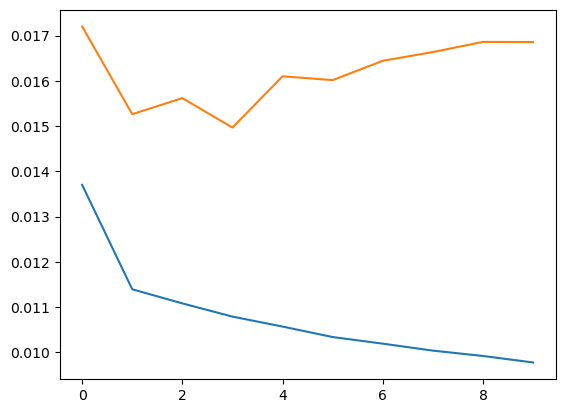

In [7]:
plt.plot(train_loss_history, linestyle="solid")
plt.plot(validation_loss_history, linestyle="solid")

# Testing the loaded in model

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def test_model(test_loader, model):   
    total = 0
    correct = 0
    incorrect = 0
    
    y_pred = []
    y_true = []
    
    model.eval()
    
    with torch.no_grad():
        
        for i, (batch_inputs, batch_labels) in enumerate(test_loader):
            out = model(batch_inputs)
            
            targets = torch.flatten(batch_labels)
            out = torch.flatten(out)
            
            fire_predictions = torch.round(torch.sigmoid(out))
            
            y_pred.extend(fire_predictions)
            y_true.extend(targets)
            
            correct += torch.sum(fire_predictions == targets)
            incorrect += torch.sum(fire_predictions != targets)
            
            total += len(targets)
    
    accuracy = 100 * correct/total
    print(f"Total = {total}")
    print(f"This should match the total: {correct + incorrect}")
    print(f"Total correct = {correct}")
    print(f"Total incorrect = {incorrect}")
    print(f"Overall accuracy: {accuracy}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nPrecision, Recall, Fscore, Support:")
    print(np.vstack(precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])))

In [9]:
test_model(test_loader, model)

Total = 1410048
This should match the total: 1410048
Total correct = 1337660
Total incorrect = 72388
Overall accuracy: 94.86627197265625

Confusion Matrix:
[[1317739   50608]
 [  21780   19921]]

Precision, Recall, Fscore, Support:
[[9.83740432e-01 2.82451190e-01]
 [9.63015229e-01 4.77710367e-01]
 [9.73267510e-01 3.55003119e-01]
 [1.36834700e+06 4.17010000e+04]]


# Plotting the loaded in model

In [10]:
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

def plot_5_predictions(loader, model, offset, titles):
    with torch.no_grad():
        batch = next(iter(loader))
        out = model(batch[0])
        fire_predictions = torch.squeeze(torch.round(torch.sigmoid(out)), dim=1).numpy()
        
        print(fire_predictions.shape)
    
        n_rows = 5
        n_features = batch[0].shape[1]
    
        CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
        BOUNDS = [-1, -0.1, 0.1, 1]
        NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
        fig = plt.figure(figsize=(15,6.5))
    
    for i in range(n_rows):
        for j in range(n_features + 2):
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
            if i == 0:
                plt.title(titles[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(batch[0][i+offset, j, :, :], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(batch[0][i+offset, -1, :, :], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(batch[1][i+offset, 0, :, :], cmap=CMAP, norm=NORM)
            if j > n_features:
                plt.imshow(fire_predictions[i+offset], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()
    

In [11]:
#https://stackoverflow.com/questions/27671748/how-to-show-y-axis-label-horizontally-in-a-matplotlib-chart
#https://stackoverflow.com/questions/49155654/remove-subplot-but-keep-axis-label-in-matplotlib


def plot_preds_and_targets(loader, model, offset):
    with torch.no_grad():
        batch = next(iter(loader))
        out = model(batch[0])
        fire_predictions = torch.squeeze(torch.round(torch.sigmoid(out)), dim=1).numpy()
    
        n_rows = 3
        n_cols = 8
    
        CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
        BOUNDS = [-1, -0.1, 0.1, 1]
        NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
        fig = plt.figure(figsize=(15,5))
    
    for i in range(n_rows):
        for j in range(n_cols + 1):
            plt.subplot(n_rows, n_cols + 1, i * (n_cols + 1) + j + 1)
            if i == 0:
                if j == 0:
                    plt.text(0.4, 0.45, "Previous\nfire\nmask", fontsize=12)
                else:
                    plt.imshow(batch[0][j+offset, -1, :, :], cmap=CMAP, norm=NORM)
            elif i == 1:
                if j == 0:
                    plt.text(0.4, 0.45, "Fire\nmask", fontsize=12)
                else:
                    plt.imshow(batch[1][j-1+offset, 0, :, :], cmap=CMAP, norm=NORM)
            else:
                if j == 0:
                    plt.text(0.4, 0.45, "Predicted\nfire\nmask", fontsize=12)
                else:
                    plt.imshow(fire_predictions[j+offset], cmap=CMAP, norm=NORM)
            plt.axis("off")

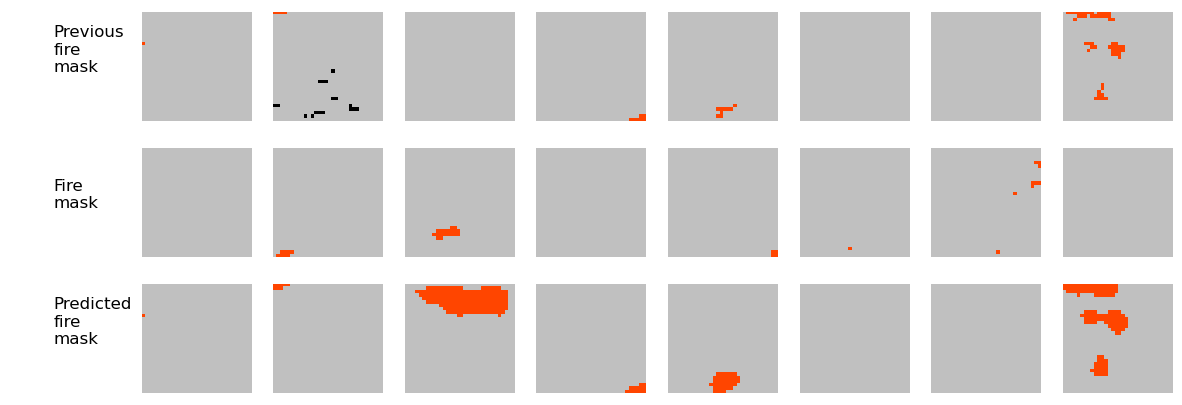

In [12]:
plot_preds_and_targets(test_loader, model, offset=5)

(50, 32, 32)


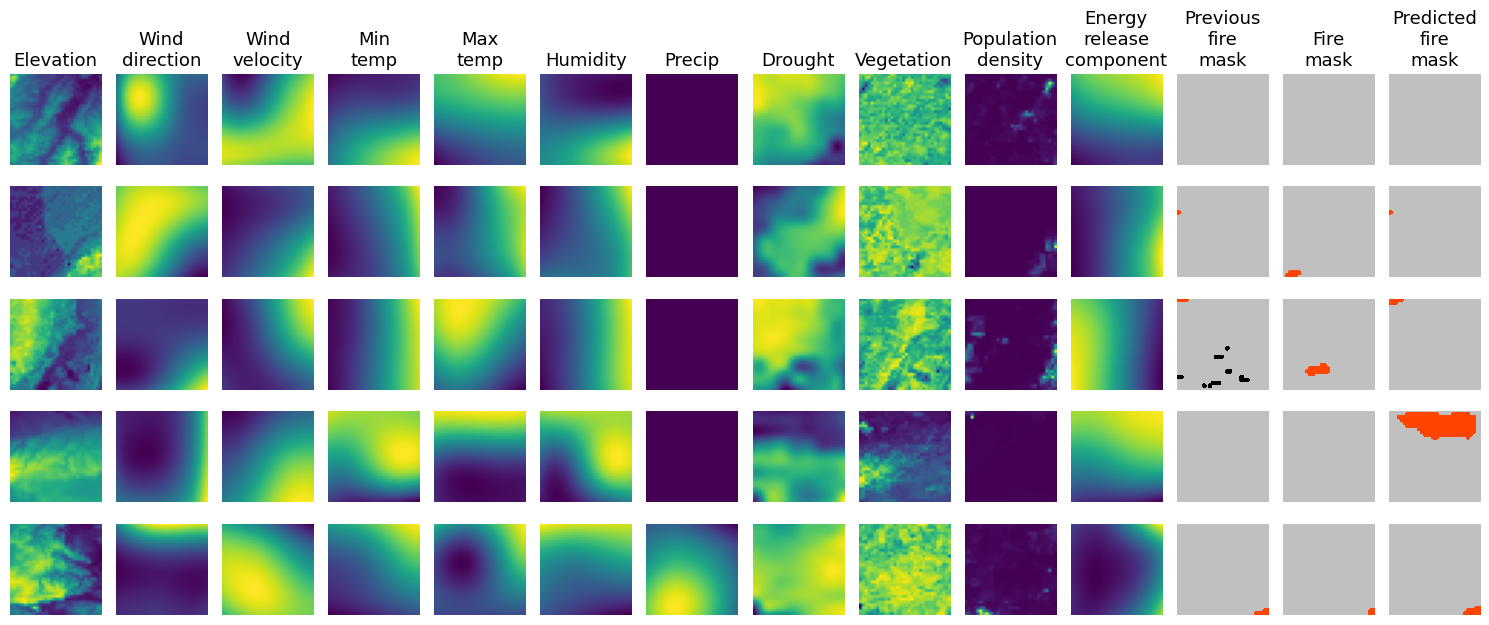

In [13]:
plot_5_predictions(test_loader, model, offset=5, titles=TITLES)